# Step 1 : Import Necessary libraries and packages

In [ ]:
!pip install pandas torch transformers datasets scikit-learn

In [ ]:
import torch

# Step 2 : Device and Environment Check

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')  # CUDA GPU
elif torch.backends.mps.is_available():
    device = torch.device('mps') #Apple GPU
else:
    device = torch.device("cpu")

In [ ]:
print('Using device:', device)
#Additional Info when using cuda
if device.type == 'cuda':
    print("Device name: ", torch.cuda.get_device_name(0))
    print("Device properties:", torch.cuda.get_device_properties(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
Device name:  Tesla T4
Device properties: _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)
Memory Usage:
Allocated: 0.6 GB
Cached:    0.8 GB


# Step 3 - Load Chosen dataset

In [ ]:
import pandas as pd
from datasets import load_dataset
import numpy as np

In [ ]:
review_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023","raw_review_All_Beauty")

# User Reviews dataframe (reviews are in the 'train' split)
reviews_df = pd.DataFrame(review_dataset['full'])

In [ ]:
#To check length of the dataset
print(len(reviews_df))

701528


# Step 4 -  Data Check and preprocessing

In [ ]:

import pandas as pd

# Print the total number of records
print("Total number of records:", len(reviews_df))

# Check for missing values
print("\nMissing values per column:")
print(reviews_df.isnull().sum())

# Exclude unhashable columns when checking for duplicates
unhashable_columns = [col for col in reviews_df.columns if reviews_df[col].apply(type).isin([list, dict]).any()]
print("\nUnhashable columns excluded for duplicate check:", unhashable_columns)

# Check duplicates only on hashable columns
hashable_df = reviews_df.drop(columns=unhashable_columns)
duplicate_rows = hashable_df.duplicated()

print("\nNumber of duplicate rows:", duplicate_rows.sum())





Total number of records: 701528

Missing values per column:
rating               0
title                0
text                 0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
dtype: int64

Unhashable columns excluded for duplicate check: ['images']

Number of duplicate rows: 7275


In [ ]:

# Columns to check for duplicates
key_columns = ['asin', 'user_id']

# Remove duplicates based on key columns and keep the first occurrence
reviews_df_cleaned = reviews_df.drop_duplicates(subset=key_columns, keep='first')

# Print the number of rows before and after removing duplicates
print("Original number of rows:", len(reviews_df))
print("Number of rows after removing duplicates:", len(reviews_df_cleaned))

# update the original dataframe
reviews_df = reviews_df_cleaned

# Confirm the change
print("\nDuplicates based on ASIN and user_id have been removed.")


Original number of rows: 701528
Number of rows after removing duplicates: 694252

Duplicates based on ASIN and user_id have been removed.


In [ ]:
# Map user_id and parent_asin to indices
user_map = {user: idx for idx, user in enumerate(reviews_df["user_id"].unique())}
item_map = {asin: idx for idx, asin in enumerate(reviews_df["parent_asin"].unique())}


In [ ]:
meta_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023","raw_meta_All_Beauty")

# User Reviews dataframe (reviews are in the 'train' split)
meta_df = pd.DataFrame(meta_dataset['full'])

# Step 5 - Split dataset for training


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
reviews_df["user_idx"] = reviews_df["user_id"].map(user_map)
reviews_df["item_idx"] = reviews_df["parent_asin"].map(item_map)

# Train-test split
train, test = train_test_split(reviews_df, test_size=0.2, random_state=42)

#NCF model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=32, hidden_dims=[64, 32], dropout_rate=0.5):
        super(NCF, self).__init__()
        # Embedding layers
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

        # Neural layers
        input_dim = embedding_dim * 2
        layers = []
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim
        self.mlp = nn.Sequential(*layers)

        # Final prediction layer
        self.output = nn.Linear(hidden_dims[-1], 1)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, user_idx, item_idx):
        # Embeddings
        user_emb = self.user_embedding(user_idx)
        item_emb = self.item_embedding(item_idx)

        # Concatenate and pass through MLP
        x = torch.cat([user_emb, item_emb], dim=-1)
        x = self.mlp(x)

        x = self.dropout(x)

        # Prediction
        return torch.sigmoid(self.output(x))


#Step 6- Prepare Dataloader

In [ ]:
from torch.utils.data import Dataset, DataLoader

class ReviewsDataset(Dataset):
    def __init__(self, data):
        self.user_idx = data["user_idx"].values
        self.item_idx = data["item_idx"].values
        self.rating = data["rating"].values

    def __len__(self):
        return len(self.rating)

    def __getitem__(self, idx):
        return {
            "user_idx": torch.tensor(self.user_idx[idx], dtype=torch.long),
            "item_idx": torch.tensor(self.item_idx[idx], dtype=torch.long),
            "rating": torch.tensor(self.rating[idx], dtype=torch.float),
        }

# Create DataLoaders
train_dataset = ReviewsDataset(train)
test_dataset = ReviewsDataset(test)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False,num_workers=4, pin_memory=True)


# Step 7 - Training

In [ ]:
results = {"train_loss": [],
            "train_acc": [],
            "train_rmse": [],  # Add RMSE for training
            "test_loss": [],
            "test_acc": [],
            "test_rmse": []  # Add RMSE for testing
    }

In [ ]:

import torch.nn.functional as F

def train_model(model, train_loader, test_loader, epochs=10, lr=0.001, lr_decay_step=5, lr_decay_gamma=0.1):
    model.to("cuda")  # Move model to GPU
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step, gamma=lr_decay_gamma)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_mae = 0
        train_rmse = 0  # Initialize RMSE accumulator

        for batch in train_loader:
            user_idx = batch["user_idx"].to("cuda")
            item_idx = batch["item_idx"].to("cuda")
            ratings = batch["rating"].to("cuda")

            optimizer.zero_grad()
            predictions = model(user_idx, item_idx).squeeze()
            loss = criterion(predictions, ratings / 5.0)  # Normalize ratings
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_mae += torch.abs(predictions - (ratings / 5.0)).sum().item()
            train_rmse += torch.sqrt((predictions - (ratings / 5.0))**2).sum().item()  # RMSE calculation

        avg_train_loss = train_loss / len(train_loader)
        avg_train_mae = train_mae / len(train_loader.dataset)
        avg_train_rmse = train_rmse / len(train_loader.dataset)  # Normalize RMSE

        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train MAE: {avg_train_mae:.4f}, Train RMSE: {avg_train_rmse:.4f}")
        results["train_loss"].append(avg_train_loss)
        results["train_acc"].append(avg_train_mae)
        results["train_rmse"].append(avg_train_rmse)  # Track RMSE

        scheduler.step()

        evaluate_model(model, test_loader)

def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    test_mae = 0
    test_rmse = 0  # Initialize RMSE accumulator
    with torch.no_grad():
        for batch in test_loader:
            user_idx = batch["user_idx"].to("cuda")
            item_idx = batch["item_idx"].to("cuda")
            ratings = batch["rating"].to("cuda")

            predictions = model(user_idx, item_idx).squeeze()
            loss = nn.MSELoss()(predictions, ratings / 5.0)

            test_loss += loss.item()
            test_mae += torch.abs(predictions - (ratings / 5.0)).sum().item()
            test_rmse += torch.sqrt((predictions - (ratings / 5.0))**2).sum().item()  # RMSE calculation

        avg_test_loss = test_loss / len(test_loader)
        avg_test_mae = test_mae / len(test_loader.dataset)
        avg_test_rmse = test_rmse / len(test_loader.dataset)  # Normalize RMSE

    print(f"Test Loss: {avg_test_loss:.4f}, Test MAE: {avg_test_mae:.4f}, Test RMSE: {avg_test_rmse:.4f}")
    results["test_loss"].append(avg_test_loss)
    results["test_acc"].append(avg_test_mae)
    results["test_rmse"].append(avg_test_rmse)  # Track RMSE


In [ ]:
num_users = len(user_map)
num_items = len(item_map)

# Initialize model
ncf_model = NCF(num_users=num_users, num_items=num_items, embedding_dim=16, hidden_dims=[32, 16])

# Train the model
train_model(ncf_model, train_loader, test_loader, epochs=10, lr=1e-4)


Epoch 1, Train Loss: 0.1100, Train MAE: 0.3010, Train RMSE: 0.3010
Test Loss: 0.0909, Test MAE: 0.2687, Test RMSE: 0.2687
Epoch 2, Train Loss: 0.0941, Train MAE: 0.2691, Train RMSE: 0.2691
Test Loss: 0.0901, Test MAE: 0.2644, Test RMSE: 0.2644
Epoch 3, Train Loss: 0.0928, Train MAE: 0.2670, Train RMSE: 0.2670
Test Loss: 0.0901, Test MAE: 0.2643, Test RMSE: 0.2643
Epoch 4, Train Loss: 0.0919, Train MAE: 0.2659, Train RMSE: 0.2659
Test Loss: 0.0901, Test MAE: 0.2642, Test RMSE: 0.2642
Epoch 5, Train Loss: 0.0913, Train MAE: 0.2651, Train RMSE: 0.2651
Test Loss: 0.0900, Test MAE: 0.2636, Test RMSE: 0.2636
Epoch 6, Train Loss: 0.0910, Train MAE: 0.2646, Train RMSE: 0.2646
Test Loss: 0.0900, Test MAE: 0.2636, Test RMSE: 0.2636
Epoch 7, Train Loss: 0.0910, Train MAE: 0.2645, Train RMSE: 0.2645
Test Loss: 0.0900, Test MAE: 0.2636, Test RMSE: 0.2636
Epoch 8, Train Loss: 0.0909, Train MAE: 0.2645, Train RMSE: 0.2645
Test Loss: 0.0900, Test MAE: 0.2636, Test RMSE: 0.2636
Epoch 9, Train Loss: 0.0

#Step 8 - Plot loss and metric curves

In [ ]:

import matplotlib.pyplot as plt

def plot_loss_curves(results):
    epochs = range(1, len(results["train_loss"]) + 1)

    plt.figure(figsize=(18, 6))

    # Plot Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, results["train_loss"], label="train_loss")
    plt.plot(epochs, results["test_loss"], label="test_loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Accuracy (if you want accuracy or MAE)
    plt.subplot(1, 3, 2)
    plt.plot(epochs, results["train_acc"], label="train_acc")
    plt.plot(epochs, results["test_acc"], label="test_acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (MAE)")
    plt.legend()

    # Plot RMSE
    plt.subplot(1, 3, 3)
    plt.plot(epochs, results["train_rmse"], label="train_rmse")
    plt.plot(epochs, results["test_rmse"], label="test_rmse")
    plt.xlabel("Epochs")
    plt.ylabel("RMSE")
    plt.legend()

    plt.tight_layout()
    plt.show()





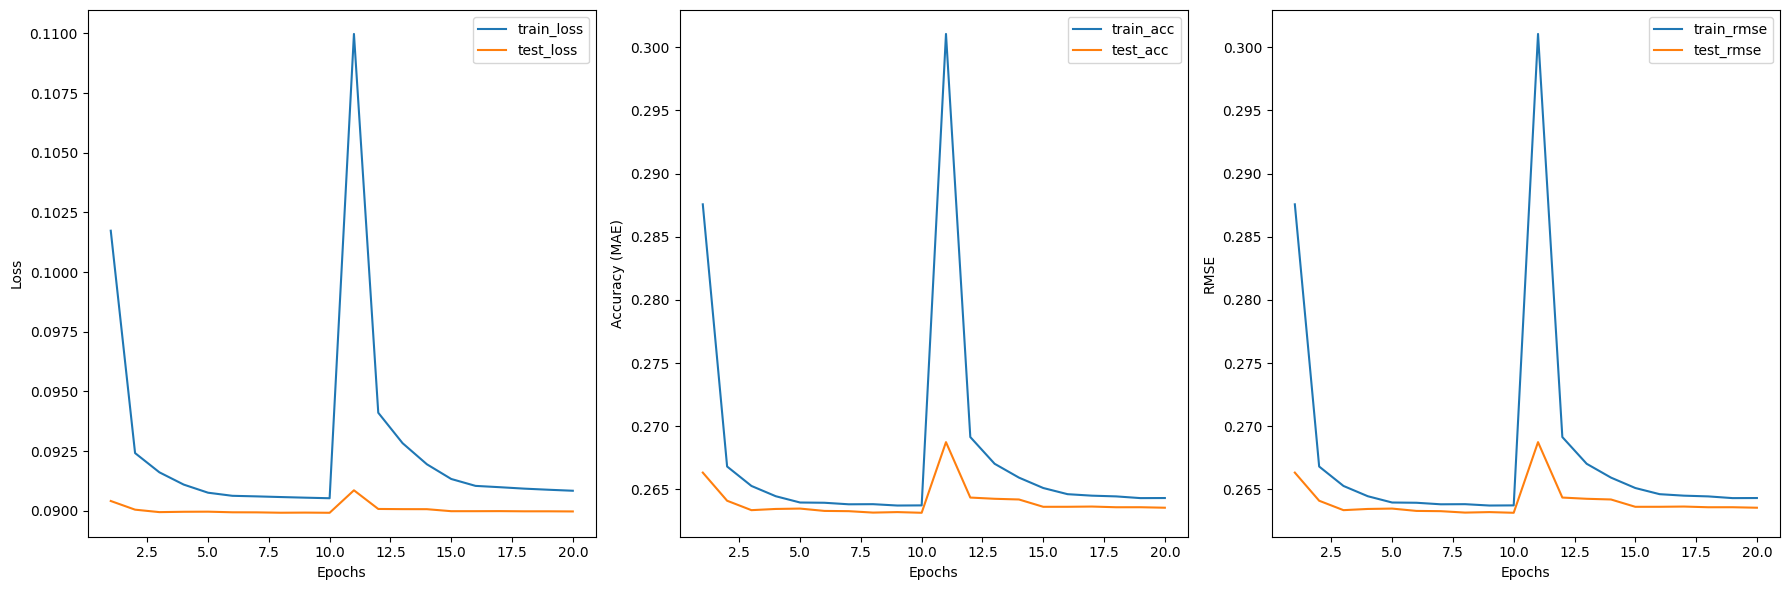

In [ ]:
plot_loss_curves(results)

#Recommendations

In [ ]:
# Example recommendation for a user
user_id = "AHZM3GVSTF4MCGO67QFLXCNIXSIQ"
user_index = user_map[user_id]

In [ ]:
def recommend(model, user_idx, item_indices, k=10 , batch_size=512):
    model.eval()
    user_tensor = torch.tensor([user_idx] * len(item_indices)).to("cuda")
    item_tensor = torch.tensor(item_indices).to("cuda")

    with torch.no_grad():
        predictions = model(user_tensor, item_tensor).squeeze()
    top_k_items = torch.topk(predictions, k=k).indices.cpu().numpy()
    return [list(item_map.keys())[i] for i in top_k_items]


item_indices = list(range(len(item_map)))
recommendations = recommend(ncf_model, user_index, item_indices)
print("Recommended items:", recommendations)


Recommended items: ['B08BBQ29N5', 'B099DRHW5V', 'B08BZ63GMJ', 'B00R8DXL44', 'B081TJ8YS3', 'B00YQ6X8EO', 'B097R46CSY', 'B09JS339BZ', 'B08P2DZB4X', 'B086QY6T7N']



#Step 9 - Latency Computation



In [ ]:


import time

def measure_latency(model, user_idx, item_idx, device, iterations=100):
    model.to(device)
    model.eval()
    user_idx = user_idx.to(device)
    item_idx = item_idx.to(device)

    # Warm-up to stabilize GPU timing (if applicable)
    for _ in range(10):
        _ = model(user_idx, item_idx)

    start_time = time.time()
    for _ in range(iterations):
        with torch.no_grad():
            _ = model(user_idx, item_idx)
    total_time = time.time() - start_time

    average_latency = (total_time / iterations) * 1000  # Convert to milliseconds
    return average_latency

# Example usage:
sample_user_idx = torch.tensor([0] * 256, dtype=torch.long)  # Simulate batch size of 256
sample_item_idx = torch.tensor([0] * 256, dtype=torch.long)

original_model_latency = measure_latency(ncf_model, sample_user_idx, sample_item_idx, device, iterations=100)

# Script the model for production
scripted_model = torch.jit.script(ncf_model)
scripted_model_latency = measure_latency(scripted_model, sample_user_idx, sample_item_idx, device, iterations=100)

# Print latencies
print(f"Average latency for original model: {original_model_latency:.2f} ms")
print(f"Average latency for scripted model: {scripted_model_latency:.2f} ms")
print(f"Speedup: {original_model_latency / scripted_model_latency:.2f}x")



Average latency for original model: 0.22 ms
Average latency for scripted model: 0.14 ms
Speedup: 1.54x


#Step 10 - UI interface

In [ ]:
import gradio as gr
import torch
from PIL import Image
import requests
from io import BytesIO

# Function to fetch item images from the DataFrame
def fetch_item_images_from_df(asins, meta_df):
    items_with_images = []
    for asin in asins:
        row = meta_df[meta_df["parent_asin"] == asin]
        if not row.empty:
            images = row["images"].iloc[0]
            if images:  # Check if images are available
                items_with_images.append([images["large"][0], row["title"].iloc[0]])
    return items_with_images

# Function to recommend and fetch images for bought and recommended items
def recommend_and_display(user_id):
    user_index = user_map.get(user_id)
    if user_index is None:
        return [], []  # Return empty lists if user not found

    # Fetch ASINs for bought items
    bought_asins = reviews_df[reviews_df["user_id"] == user_id]["parent_asin"].tolist()

    # Fetch images for bought and recommended items
    bought_items = fetch_item_images_from_df(bought_asins, meta_df)
    recommended_asins = recommend(ncf_model, user_index, list(range(len(item_map))))
    recommended_items = fetch_item_images_from_df(recommended_asins, meta_df)

    return bought_items, recommended_items

# Gradio function to display the recommendations
def gradio_interface(user_id):
    bought, recommended = recommend_and_display(user_id)
    return bought, recommended

# Gradio Interface
interface = gr.Interface(
    fn=gradio_interface,
    inputs=gr.Textbox(label="Enter User ID"),
    outputs=[
        gr.Gallery(label="Bought Items"),
        gr.Gallery(label="Recommended Items")
    ],
    title="Amazon Recommender",
    description="Enter a User ID to see images of bought and recommended items.",
    live=True
)

# Launch Gradio Interface
interface.launch(share=True)
